# Reconstruction problem notebook

In [44]:
from torch import nn
class ThisModel(nn.Module):
    def __init__(self, size):
        super(ThisModel, self).__init__()

        # Encoder
        self.size = size


        self.linear_block = nn.Sequential(
            nn.SELU(),
            nn.Linear(size * size, 1),
            
        )

        #self.lin1 = nn.Linear

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.dp = nn.Dropout()



    def forward(self, x):
        bs = x.size()[0]

        x = self.linear_block(x.view(bs, self.size * self.size))


       

        return x
    
def test():
    device = torch.device("cuda:0")
    model = ThisModel(80).to(device).eval()
    x = torch.randn(1, 1, 80, 80, device=device)
    print(model(x).size())

    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))

test()

torch.Size([1, 1])
params 6601


In [128]:
from torch import nn
class ThisModel(nn.Module):
    def __init__(self, size):
        super(ThisModel, self).__init__()

        # Encoder
        self.size = size


        self.linear_block = nn.Sequential(
            nn.Linear(size * size + 1, size * size),
            nn.Sigmoid(),
            nn.Linear(size * size, size * size - 600),
            nn.Sigmoid(),
            nn.Linear(size * size - 600, size * size),
            nn.Sigmoid(),
            
        )

        #self.lin1 = nn.Linear

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.dp = nn.Dropout()



    def forward(self, x, k0):
        bs = x.size()[0]
        x = torch.cat((x.view(self.size * self.size, bs), k0.view(1, bs))).view(bs, self.size * self.size + 1)
        x = self.linear_block(x).view(bs, 1, self.size, self.size)


       

        return x
    
def test():
    device = torch.device("cpu:0")
    model = ThisModel(80).to(device).eval()
    x = torch.randn(1, 1, 80, 80, device=device)
    k0 = torch.randn(1, 1, 1, 1, device=device)
    print(model(x, k0).size())

    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))

test()

torch.Size([1, 1, 80, 80])
params 115225000


In [24]:
import torch
from torch import nn
class ThisModel(nn.Module):
    def __init__(self, size):
        super(ThisModel, self).__init__()

        # Encoder
        self.size = size


        self.linear_block = nn.Sequential(
            nn.Linear(2 * size ** 2, size * size),
            nn.SELU(),
            nn.Linear(size * size, size * size - 600),
            nn.Sigmoid(),
            nn.Linear(size * size - 600, size * size),
            nn.Sigmoid(),
            
        )

        #self.lin1 = nn.Linear

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.dp = nn.Dropout()



    def forward(self, x1, x2):
        bs = x1.size()[0]
        inp_size = int(2 * self.size ** 2 + 1)
        x = torch.cat((x1.view(self.size * self.size, bs), x2.view(self.size * self.size, bs))).view(bs, 2 * self.size ** 2)
        x = self.linear_block(x).view(bs, 1, self.size, self.size)


       

        return x
    
def test():
    device = torch.device("cpu:0")
    model = ThisModel(80).to(device).eval()
    x1 = torch.randn(1, 1, 80, 80, device=device)
    x2 = torch.randn(1, 1, 80, 80, device=device)
    print(model(x1, x2).size())

    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))

test()

torch.Size([1, 1, 80, 80])
params 156178600


In [1]:
import torch
from torch import nn
class ThisModel(nn.Module):
    def __init__(self, size: int):
        super(ThisModel, self).__init__()

        # Encoder
        self.size: int = size


        self.linear_block = nn.Sequential(
            nn.Linear(2 * size ** 2 + 1, size * size),
            nn.SELU(),
            nn.Linear(size * size, size * size - 600),
            nn.SELU(),
            nn.Linear(size * size - 600, size * size),
            
        )

        #self.lin1 = nn.Linear

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.dp = nn.Dropout()



    def forward(self, x1, x2, k0):
        bs = x1.size()[0]
        inp_size = int(2 * self.size ** 2 + 1)
        x = torch.cat((x1.view(self.size * self.size, bs), x2.view(self.size * self.size, bs))).view(bs, inp_size - 1)
        x = torch.cat((x.view(inp_size - 1, bs), k0.view(1, bs))).view(bs, inp_size)
        x = self.linear_block(x).view(bs, 1, self.size, self.size)


       

        return x
    
def test():
    device = torch.device("cpu:0")
    model = ThisModel(80).to(device).eval()
    x1 = torch.randn(1, 1, 80, 80, device=device)
    x2 = torch.randn(1, 1, 80, 80, device=device)
    k0 = torch.randn(1, 1, 1, 1, device=device)
    print(model(x1, x2, k0).size())

    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))

test()

torch.Size([1, 1, 80, 80])
params 156185000


In [14]:
import torch
from torch import nn
class ThisModel(nn.Module):
    def __init__(self, size: int):
        super(ThisModel, self).__init__()

        # Encoder
        self.size: int = size


        self.linear_block = nn.Sequential(
            nn.Linear(2 * size ** 2 + 1, size * size),
            nn.Sigmoid(),
            nn.Linear(size * size, size * size - 600),
            nn.Sigmoid(),
            nn.Linear(size * size - 600, size * size),
            nn.Sigmoid(),
            
        )

        #self.lin1 = nn.Linear

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.dp = nn.Dropout()



    def forward(self, x1, x2, k0):
        bs = x1.size()[0]
        inp_size = int(2 * self.size ** 2 + 1)
        x = torch.cat((x1.view(self.size * self.size, bs), x2.view(self.size * self.size, bs))).view(bs, inp_size - 1)
        x = torch.cat((x.view(inp_size - 1, bs), k0.view(1, bs))).view(bs, inp_size)
        x = self.linear_block(x).view(bs, 1, self.size, self.size)


       

        return x
    
def test():
    device = torch.device("cpu:0")
    model = ThisModel(80).to(device).eval()
    x1 = torch.randn(1, 1, 80, 80, device=device)
    x2 = torch.randn(1, 1, 80, 80, device=device)
    k0 = torch.randn(1, 1, 1, 1, device=device)
    print(model(x1, x2, k0).size())

    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))

test()

torch.Size([1, 1, 80, 80])
params 156185000


In [70]:
import torch
from torch import nn
class ThisModel(nn.Module):
    def __init__(self, size):
        super(ThisModel, self).__init__()

        # Encoder
        self.size = size


        self.linear_block = nn.Sequential(
            nn.Linear(2 * size ** 2, size * size),
            nn.ReLU(),
            nn.Linear(size * size, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1),
            nn.ReLU(),

            
        )

        #self.lin1 = nn.Linear

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

        self.dp = nn.Dropout()



    def forward(self, x1, x2):
        bs = x1.size()[0]
        inp_size = int(2 * self.size ** 2)
        x = torch.cat((x1.view(self.size * self.size, bs), x2.view(self.size * self.size, bs))).view(bs, inp_size)
        x = self.linear_block(x)


       

        return x
    
def test():
    device = torch.device("cpu:0")
    model = ThisModel(80).to(device).eval()
    x1 = torch.randn(1, 1, 80, 80, device=device)
    x2 = torch.randn(1, 1, 80, 80, device=device)
    print(model(x1, x2).size())

    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))

test()

torch.Size([1, 1])
params 95037697


=================================================================================================================

## Библиотеки, параметры, константы задачи

In [2]:
from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
from common.fstream import read_tensor, read_matrix, rescale_array

PATH_BASE = "/home/amedvedev/projects/python/DenoisingCNN"
NAME_DATASET = "gcg19"
env = PolyFeaturesEnv(name_model="model_20", name_dataset=NAME_DATASET, path_base=PATH_BASE,
                      device_name="cuda")


## Загрузка данных

### Восстанавление $\left|k\right|$ по $\left|y_{выч}\right|$, разделённому на левую ($\left|y_{выч}\right|_{L}$) и правую ($\left|y_{выч}\right|_{R}$) части

In [3]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=40, height=80, feature_name="Uvych_abs_left.xls", mapper=read_matrix
    ) \
    .load_feature(
        width=40, height=80, feature_name="Uvych_abs_right.xls", mapper=read_matrix
    ) \
    .set_target(
        width=80, height=80, target_name="K_abs.xls", mapper=read_tensor
    ) \
    

print(env.train_count, env.val_count)


AssertionError: 

### Восстанавление $\left|k\right|$ из $\tilde{\left|k\right|}$ (noised)

In [3]:
mapper_div = lambda path: read_matrix(path, coeff_norm=65.) # 140

env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=16, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="K_noised_abs.xls", mapper=mapper_div, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="K_abs.xls", mapper=mapper_div, transform=None
    ) \
    
print(env.train_count, env.val_count)

57 16


### Восстанавление $\left|k-k_{0}\right|$ из $\left|k-k_{0}\right|$ (noised)

In [2]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=4, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="K-k0_noised_abs.xls", mapper=read_tensor, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="K-k0_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

231 16


### Восстанавление $\left|k\right|$ из $\left|y_{выч}\right|$ 

In [94]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_abs.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="K_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)


28 16


### Восстанавление $\left|W\right|$ из $\left|y_{выч}\right|$ & $K_{0}$ 


In [133]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_abs.xls", mapper=read_matrix, transform=None
    ) \
    .load_feature(
        width=1, height=1, feature_name="k0_re.txt", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="W_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

28 16


### Восстанавление $\left|W\right|$ по комплексному $y_{выч}$

In [15]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_re.xls", mapper=read_matrix, transform=None
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_im.xls", mapper=read_matrix, transform=None
    ) \
    .load_feature(
        width=1, height=1, feature_name="k0_re.txt", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="W_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

28 16


### Восстанавление $Re\left[k_{0}\right]$ по комплексному $y_{выч}$ 

In [37]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_re.xls", mapper=read_matrix, transform=None
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_im.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=1, height=1, target_name="k0_re.txt", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

28 16


### Восстанавление $\left|K\right|$ по комплексному $y_{выч}$ и $Re\left[k_{0}\right]$

In [3]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_re.xls", mapper=read_matrix, transform=None
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_im.xls", mapper=read_matrix, transform=None
    ) \
    .load_feature(
        width=1, height=1, feature_name="k0_re.txt", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="K_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

28 16


### Восстанавление $Re\left[k_{0}\right]$ из $\left|y_{выч}\right|$ 

In [45]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="Uvych2_abs.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=1, height=1, target_name="k0_re.txt", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)


28 16


### Восстанавление $\left|y_{выч}\right|$ из $\left|k\right|$ 

In [2]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=8, val_batch_size=4
    ) \
    .load_feature(
        width=80, height=80, feature_name="K_abs.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="Uvych2_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

115 16


### Восстанавление $\left|y_{выч}\right|_{L}$ из $\left|\tilde{y}_{выч}\right|_{L}$ (noised)


In [2]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=4, val_batch_size=4
    ) \
    .load_feature(
        width=40, height=80, feature_name="Uvych_noised_abs_left.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=40, height=80, target_name="Uvych_abs_left.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

231 16


===================================================================================================================================

## Модели

### VQGAN

In [3]:
env.model = models.vqgan.VQGAN_mod(type('', (object, ), 
    {'image_channels': 1, 'latent_dim': 256, 'device': env.device_name, 
     'num_codebook_vectors': 1024, 'beta': 0.25})()).to(env.device)

### U-net

In [4]:
env.model = models.UnetAutoencoder.UNetAuto(num_channels=1, num_out_channels=1, max_features=1024).to(env.device)

### Hybrid Perception Block 

In [3]:
from ITTR_pytorch import HPB
env.model = HPB(
    dim = 1,              # dimension
    dim_head = 80,          # dimension per attention head
    heads = 8,              # number of attention heads
    attn_height_top_k = 16, # number of top indices to select along height, for the attention pruning
    attn_width_top_k = 16,  # number of top indices to select along width, for the attention pruning
    attn_dropout = 0.,      # attn dropout
    ff_mult = 4,            # expansion factor of feedforward
    ff_dropout = 0.         # feedforward dropout
).to(env.device)

### Dual-Pruned Self-Attention (DPSA) block

In [3]:
from ITTR_pytorch import DPSA


env.model = DPSA(
    dim = 1,         # dimension
    dim_head = 80,     # dimension per attention head
    heads = 8,         # number of attention heads
    height_top_k = 48, # number of top indices to select along height, for the attention pruning
    width_top_k = 48,  # number of top indices to select along width, for the attention pruning
    dropout = 0.       # attn dropout
).to(env.device)

### Новая локальная модель

In [34]:
env.init_model(models.autoencoders.ConvAutoencoderLumaRelu)

New model created.


In [92]:
env.model = ThisModel(80).to(env.device)

### Импорт претренерованной модели

In [5]:
env.load_model(model_type="pt")

===================================================================================================================================

## Визуализация батча валидационного датасета

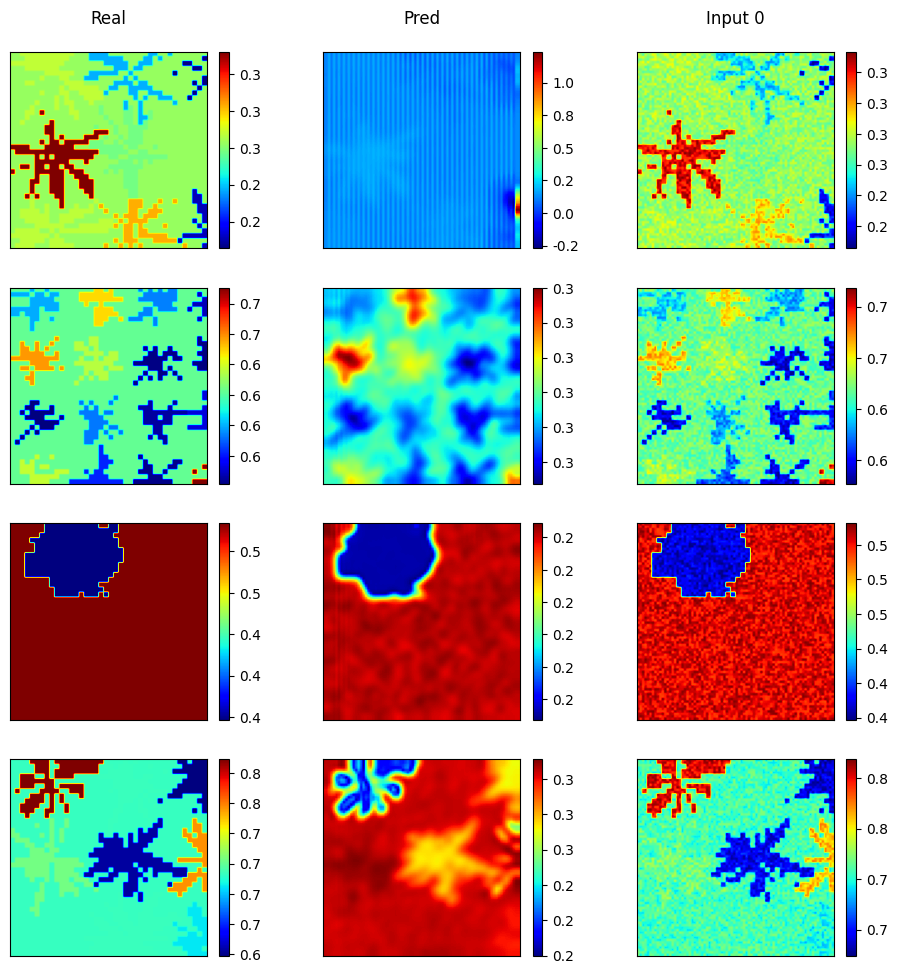

In [8]:
env.plot_batch_with_inputs(concrete=4, figsize=(10, 10), format="%.1f", wspace=0.0, hspace=0.2)

===================================================================================================================================

## Численные значения отклонений

In [7]:
def test():
    losses = []
    errors = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            outputs = env.model(*data_features) #* 65.
            loss = torch.max(torch.abs(outputs - data_target))
            error = torch.mean(torch.abs(outputs - data_target)) / torch.mean(data_target)
            losses.append(loss.detach().tolist())
            errors.append(error.detach().tolist())
            #print(outputs, data_target)
    print("Среднее отклонение по значениям в векторе:", sum(losses) / len(losses))
    print("Максимальное отклонение по значениям в векторе:", max(losses))
    print("Средняя относительная ошибка:", sum(errors) / len(errors))
    print("Максимальная относительная ошибка:", max(errors))
test()

Среднее отклонение по значениям в векторе: 0.4412460122257471
Максимальное отклонение по значениям в векторе: 1.0269063711166382
Средняя относительная ошибка: 0.43124960269778967
Максимальная относительная ошибка: 0.5775461792945862


===================================================================================================================================

## Training

In [10]:
from common.losses import MseCoeffLoss, L1CoeffLoss

In [ ]:
# optimizer = torch.optim.Adam(env.model.parameters(), lr=0.00001)
# #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.65 ** epoch)
# 
# env.train(3, step_saving=False, step_plotting=False,
#           optimizer=optimizer, scheduler=None, 
#           criterion=MyLoss(reduce="none", reduction="none", coeff=10000000.0))

In [18]:
env.train(10, step_saving=True, step_plotting=False,
          optimizer=torch.optim.RMSprop(env.model.parameters(), lr=0.01), scheduler=None, 
          criterion=torch.nn.BCELoss())

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 24.993084 	Validating Loss: 26.645335 	Time: 0.35 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 25.930419 	Validating Loss: 26.645335 	Time: 0.32 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 25.930419 	Validating Loss: 26.645334 	Time: 0.32 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Los

In [14]:
env.train(15, step_saving=False, step_plotting=False,
          optimizer=torch.optim.Adam(env.model.parameters(), lr=0.001), scheduler=None, 
          criterion=MseCoeffLoss(reduce="none", reduction="none", coeff=1.0))

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.004202 	Validating Loss: 0.013383 	Time: 0.66 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.003524 	Validating Loss: 0.012693 	Time: 0.65 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.003286 	Validating Loss: 0.012328 	Time: 0.66 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 0.0

№1

In [22]:
optimizer = torch.optim.Adam(env.model.parameters(), lr=0.00001)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.65 ** epoch)

env.train(30, step_saving=True, step_plotting=False,
          optimizer=optimizer, scheduler=None, 
          criterion=MseCoeffLoss(reduce="none", reduction="none", coeff=10.0))

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.032314 	Validating Loss: 0.041488 	Time: 0.13 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 
Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.032245 	Validating Loss: 0.041429 	Time: 0.13 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.032180 	Validating Loss: 0.041367 	Time: 0.13 m


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 0.

In [ ]:
def warmup(current_step: int):
    if current_step < args.warmup_steps:  # current_step / warmup_steps * base_lr
        return float(current_step / args.warmup_steps)
    else:                                 # (num_training_steps - current_step) / (num_training_steps - warmup_steps) * base_lr
        return max(0.0, float(args.training_steps - current_step) / float(max(1, args.training_steps - args.warmup_steps)))

In [26]:
env.train(6, step_saving=True, step_plotting=False,
          optimizer=torch.optim.Adam(env.model.parameters(), lr=0.001), scheduler=None, 
          criterion=torch.nn.MSELoss())


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.043566 	Validating Loss: 0.037385 	Time: 0.27 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.043566 	Validating Loss: 0.037385 	Time: 0.27 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.043566 	Validating Loss: 0.037385 	Time: 0.27 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 0.0

## Сохранение модели

In [17]:
env.save(onnx=False, pth=False)

## Loss visualisation

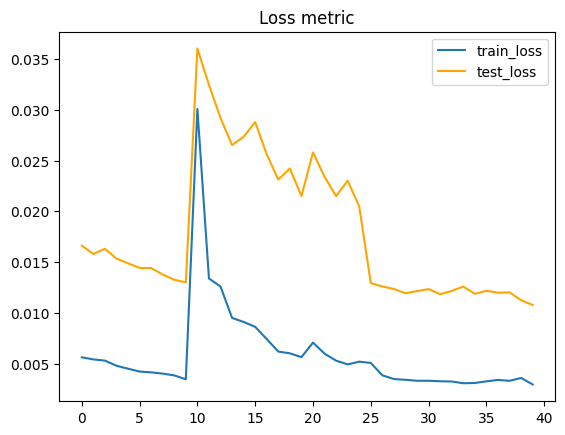

In [70]:
env.show_metrics(n_last=40, train=True, val=True)

## Clear memory

In [101]:
import gc
gc.collect()


0

In [96]:
env.model.cpu()
del env.model

torch.cuda.empty_cache()

In [102]:
torch.cuda.empty_cache()